In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change to your data directory
import os
os.chdir('/content/drive/MyDrive/Saarland')

Mounted at /content/drive


In [4]:
# Load data - only columns we need
cols = ['GAME_DATE_EST', 'SEASON', 'TEAM_ID_home', 'TEAM_ID_away', 'PTS_home', 'PTS_away']
nba = pd.read_csv('nba_games.csv', usecols=cols)

nba.head()

,GAME_DATE_EST,SEASON,TEAM_ID_home,PTS_home,TEAM_ID_away,PTS_away
0,2022-12-22,2022,1610612740,126.0,1610612759,117.0
1,2022-12-22,2022,1610612762,120.0,1610612764,112.0
2,2022-12-21,2022,1610612739,114.0,1610612749,106.0
3,2022-12-21,2022,1610612755,113.0,1610612765,93.0
4,2022-12-21,2022,1610612737,108.0,1610612741,110.0


In [5]:
# Parse dates and rename
nba['Date'] = pd.to_datetime(nba['GAME_DATE_EST'], errors='coerce')

nba = nba.rename(columns={
    'TEAM_ID_home': 'HomeTeam',
    'TEAM_ID_away': 'AwayTeam',
    'PTS_home': 'HomePts',
    'PTS_away': 'AwayPts'
})

# Remove incomplete 2022 season
nba = nba[nba['SEASON'] != 2022]

# Drop rows with missing scores
nba = nba.dropna(subset=['HomePts', 'AwayPts'])
nba['HomePts'] = nba['HomePts'].astype(int)
nba['AwayPts'] = nba['AwayPts'].astype(int)

# SEASON column is already in the format we need (e.g., 2003 for 2003-04 season)
# Keep it as is for grouping by NBA season

print(f"Total games: {len(nba)}")
print(f"Seasons: {nba['SEASON'].min()}-{nba['SEASON'].max()}")
print(f"Unique teams: {nba['HomeTeam'].nunique()}")
print(f"\nSample seasons: {sorted(nba['SEASON'].unique())[:10]}")

Total games: 26010
Seasons: 2003-2021
Unique teams: 30

Sample seasons: [np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012)]


## Calculate Per-Team Win Percentage (Peko's Method)

Following Getty et al. (2018), we calculate win percentage for each team, then use random splits to compute R*.

In [6]:
def get_team_games(df, team):
    """Get all games for a specific team"""
    home_games = df[df['HomeTeam'] == team].copy()
    home_games['is_home'] = True
    home_games['team_score'] = home_games['HomePts']
    home_games['opp_score'] = home_games['AwayPts']
    home_games['opponent'] = home_games['AwayTeam']

    away_games = df[df['AwayTeam'] == team].copy()
    away_games['is_home'] = False
    away_games['team_score'] = away_games['AwayPts']
    away_games['opp_score'] = away_games['HomePts']
    away_games['opponent'] = away_games['HomeTeam']

    team_games = pd.concat([home_games, away_games])
    team_games = team_games.sort_values('Date')

    # Calculate wins (1 for win, 0 for loss; no ties in NBA)
    team_games['win'] = (team_games['team_score'] > team_games['opp_score']).astype(int)

    return team_games

def calculate_r_peko_method(df, n_folds=100):
    """
    Calculate R* using Peko's method:
    1. For each team, randomly split games K times
    2. Calculate win percentage for each split
    3. Pool all (x,y) pairs across teams and splits
    4. Transform to S,T coordinates
    5. Calculate R = 1 - var(T)/var(S)
    """
    teams = sorted(set(df['HomeTeam']).union(set(df['AwayTeam'])))

    # Collect all (x,y) pairs
    XY_pairs = []

    for team in teams:
        team_games = get_team_games(df, team)
        n_games = len(team_games)

        # Skip teams with too few games
        if n_games < 4:
            continue

        # Perform K random splits for this team
        for k in range(n_folds):
            # Randomly assign games to fold A or B
            fold = np.random.randint(0, 2, n_games)

            games_a = team_games.iloc[fold == 0]
            games_b = team_games.iloc[fold == 1]

            # Calculate win percentage
            if len(games_a) > 0 and len(games_b) > 0:
                x = games_a['win'].sum() / len(games_a)
                y = games_b['win'].sum() / len(games_b)
                XY_pairs.append((x, y))

    if len(XY_pairs) < 3:
        return np.nan

    # Convert to arrays
    X = np.array([x for x, y in XY_pairs])
    Y = np.array([y for x, y in XY_pairs])

    # Transform to S, T coordinates
    S = (X + Y) / np.sqrt(2)
    T = (Y - X) / np.sqrt(2)

    # Calculate variances (using ddof=0)
    var_S = np.var(S, ddof=0)
    var_T = np.var(T, ddof=0)

    # Calculate R
    if var_S > 1e-12:
        R = 1 - var_T / var_S
    else:
        R = np.nan

    return R

## Calculate R by Season

In [7]:
results = []

for season in sorted(nba['SEASON'].unique()):
    season_data = nba[nba['SEASON'] == season]

    n_teams = len(set(season_data['HomeTeam']).union(set(season_data['AwayTeam'])))
    n_games = len(season_data)

    if n_games >= 20:
        r_val = calculate_r_peko_method(season_data, n_folds=100)

        results.append({
            'Season': season,
            'N_Teams': n_teams,
            'N_Games': n_games,
            'R_Value': r_val
        })

results_df = pd.DataFrame(results)
results_df = results_df.round({'R_Value': 2})
results_df

,Season,N_Teams,N_Games,R_Value
0,2003,29,1286,0.84
1,2004,30,1362,0.88
2,2005,30,1432,0.83
3,2006,30,1419,0.80
4,2007,30,1411,0.89
5,2008,30,1425,0.90
6,2009,30,1424,0.89
7,2010,30,1422,0.87
8,2011,30,1104,0.85
9,2012,30,1420,0.87


## Visualize Results

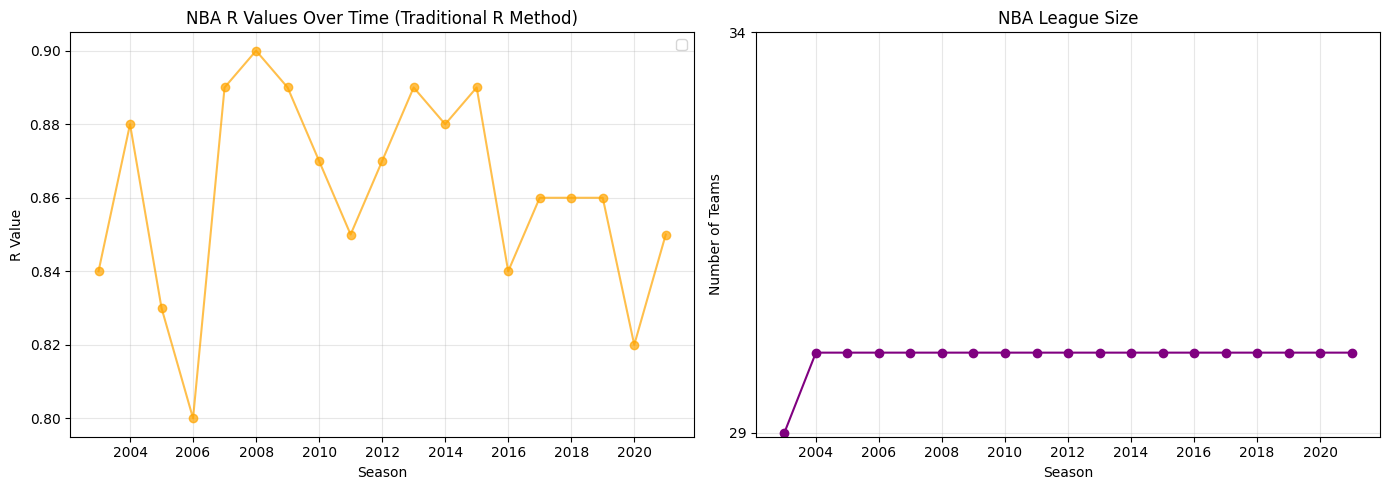

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# R values over time
ax1.plot(results_df['Season'], results_df['R_Value'], 'o-', alpha=0.7, color='orange')
#ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='R = 0.5')
ax1.set_xlabel('Season')
ax1.set_ylabel('R Value')
ax1.set_title('NBA R Values Over Time (Traditional R Method)')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Number of teams over time
ax2.plot(results_df['Season'], results_df['N_Teams'], 'o-', color='purple')
ax2.set_xlabel('Season')
ax2.set_ylabel('Number of Teams')
ax2.set_title('NBA League Size')
ax2.set_yticks(range(min(results_df['N_Teams']), max(results_df['N_Teams']) + 5, 5))
ax2.grid(alpha=0.3)
ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [9]:
# Summary statistics
print("\nOverall Summary:")
print(f"Mean R: {results_df['R_Value'].mean():.3f}")
print(f"Std R: {results_df['R_Value'].std():.3f}")
print(f"Min R: {results_df['R_Value'].min():.3f}")
print(f"Max R: {results_df['R_Value'].max():.3f}")


Overall Summary:
Mean R: 0.862
Std R: 0.027
Min R: 0.800
Max R: 0.900


## P vs Q Scatter Plot

Show first vs second half win percentage for a recent season

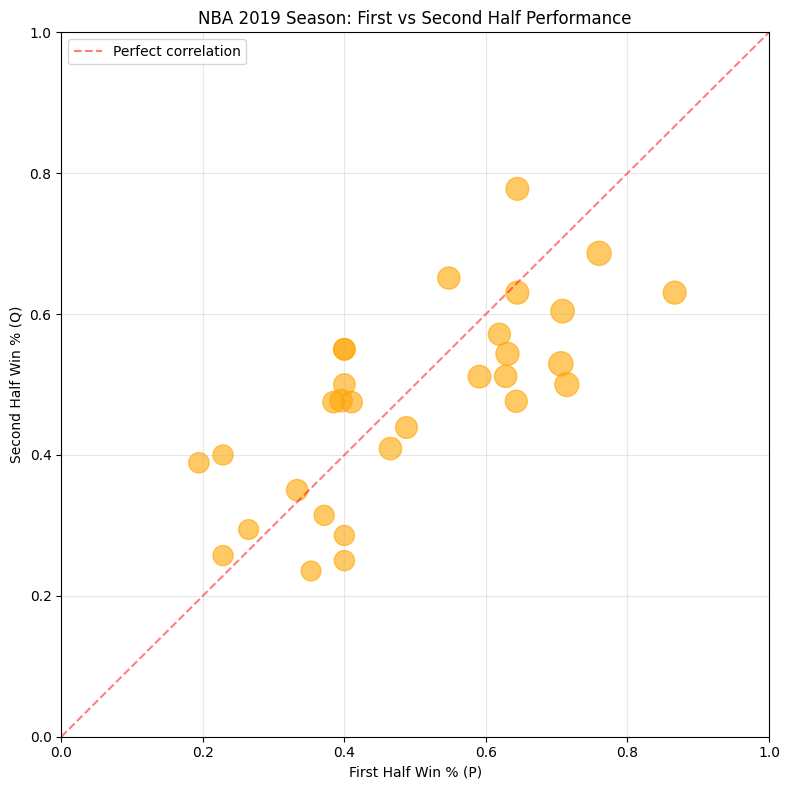


Correlation between first and second half: 0.727


In [11]:
# Analyze a recent season for visualization
example_season = 2019
season_data = nba[nba['SEASON'] == example_season]
teams = sorted(set(season_data['HomeTeam']).union(set(season_data['AwayTeam'])))

P_values = []
Q_values = []
game_counts = []

for team in teams:
    team_games = get_team_games(season_data, team)
    n_games = len(team_games)

    if n_games < 4:
        continue

    # Split into first and second half
    half = n_games // 2
    first_half = team_games.iloc[:half]
    second_half = team_games.iloc[half:]

    p = first_half['win'].sum() / len(first_half)
    q = second_half['win'].sum() / len(second_half)

    P_values.append(p)
    Q_values.append(q)
    game_counts.append(n_games)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
sizes = [g * 3 for g in game_counts]
ax.scatter(P_values, Q_values, s=sizes, alpha=0.6, color='orange')
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect correlation')
ax.set_xlabel('First Half Win % (P)')
ax.set_ylabel('Second Half Win % (Q)')
ax.set_title(f'NBA {example_season} Season: First vs Second Half Performance')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCorrelation between first and second half: {np.corrcoef(P_values, Q_values)[0,1]:.3f}")